# 異常検知まとめ

## 1. 関連統計手法

### 1-1. パーセンタイル値

平均値自体が外れ値にひっぱられる値なので、データを数字の大小の順に並べて、<br>
上位1%、下位1%を外れ値とみなすという方法。

特に箱ひげ図を使ったものはTukey法といいます。

#### 箱ひげ図とは

箱ひげ図はデータのばらつき具合を調べるために使われ、<br>
データを最小値、最大値、第1四分位、第2四分位、第3四分位に分けて表現します。

第1四分位：データ全体の1/4の部分が第1四分位です。<br>
第2四分位：データ全体の1/2の部分が第2四分位にあたり、中央値とも呼ばれます。<br>
第3四分位：データ全体の3/4の部分が第3四分位です。<br>


#### 箱ひげ図のプロット例

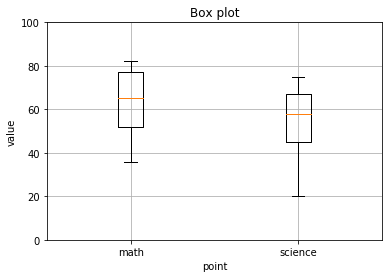

In [1]:
import matplotlib.pyplot as plt

# データの作成
date1 = [36,82,77,52,65]#数学の点数
date2 = [20,75,58,45,67]#理科の点数

hige = (date1, date2)

fig = plt.figure()
ax = fig.add_subplot(111)

# 箱ひげ図をつくる
bp = ax.boxplot(hige)
ax.set_xticklabels(['math', 'science'])

plt.title('Box plot')
plt.grid()
plt.xlabel('point')
plt.ylabel('value')
plt.ylim([0,100])
plt.show()

### 1-2. Smirnov-Grubbs検定（正規分布ベース）

スミルノフ・グラブス検定。外れ値データを検定で棄却するために使う標準の方法。

一番平均値からの差が大きい値から順に見ていき、標準化した値が以下に示す<br>
閾値よりも大きい場合に、帰無仮説を棄却し、対立仮説を採択します。

### 例題

　「母平均値 μ = 140，母標準偏差 σ = 8 である正規母集団から 20 個のデータを抽出したところ，<br>
 表 1 のような結果が得られた。この測定値の中の 164 は他と比べてかなり外れているようであるが，<br>
 このデータは捨てた方がよいだろうか。有意水準 5% で検定しなさい。」 
 
表 1．どのデータが“外れている”か<br>
133	134	134	134	135	135	139	140	140	140<br>
141	142	142	144	144	147	147	149	150	164

標本平均=141.7	標本分散=55.0632<br>


### 検定手順

(1) [前提]<br>
帰無仮説 H0：「全てのデータは同じ母集団からのものである」。<br>
対立仮説 H1：「データのうち，最大のものは外れ値である」。<br>
有意水準 α で片側検定を行う（両側検定も定義できる）。<br>

(2) 標本の大きさ n=20，標本平均 $\bar x = 141.7$, 不偏分散 $U = 55.0632 $ 

(3) 最大の測定値 $X_i$ について次式による $T_i$ を求める<br>
   （平均値より小さい方の外れ値の場合には，最小の測定値について計算する）。<br>

$\displaystyle
T_i = \frac{ |X_i - \bar x|}{\sqrt{U}} 
$

例題では
$\displaystyle
T_{20} = \frac{ |164- 141.7|}{\sqrt{55.0632}} = 3.0052
$

(4) 統計数値表から有意点 t を求める。<br>
例題では， $t = 2.557$ である。

(5) 帰無仮説の採否を決める。<br>
$T_i ＜ t$ のとき，帰無仮説を採択する。「データのうち，最大（最小）のものは外れ値であるとはいえない」。<br>
$T_i \geq t$ のとき，帰無仮説を棄却する。「データのうち，最大（最小）のものは外れ値である」。

例題では，有意水準 5% で検定を行うとすれば， $X_{20} = 164$ は“外れ値”とすることになる。

### python でスミルノフ・グラブス検定してみる

表 1．どのデータが“外れている”か<br>
133	134	134	134	135	135	139	140	140	140<br>
141	142	142	144	144	147	147	149	150	164

In [2]:
import numpy as np

#  標本データ列
x = [133, 134, 134, 134, 135, 135, 139, 140, 140, 140, 141, 142, 142, 144, 144, 147, 147, 149, 150, 164]
# 統計数値表から有意点(Critical value)  を決めておく
CR_VALUE =2.557

# 標本平均と標本分散を計算する
mean = np.mean(x, dtype=np.float64)
var     = np.var(x, dtype=np.float64)
print("mean:",mean, "variance:", var)

T = np.abs(x - mean) / np.sqrt(var)
print("T-value:",T)

# 有意点を超えるものを条件作成
cond =(T>CR_VALUE)
print(cond)

# 条件を満たす行番号の取得
anomaly_pt = np.where(cond == True)
print("anomaly points:",anomaly_pt)

mean: 141.7 variance: 52.31
T-value: [ 1.20289271  1.06462918  1.06462918  1.06462918  0.92636565  0.92636565
  0.37331153  0.235048    0.235048    0.235048    0.09678447  0.04147906
  0.04147906  0.31800612  0.31800612  0.73279671  0.73279671  1.00932377
  1.1475873   3.08327671]
[False False False False False False False False False False False False
 False False False False False False False  True]
anomaly points: (array([19]),)


### 1-3. Tietjen-Moore検定（正規分布ベース）

Smirnov-Grubbs検定を<span style="color:red">複数の外れ値を検出</span>できるように拡張した方法です。

帰無仮説：全てのデータは同じ母集団に属する　<br>
対立仮説：データのうち平均値から離れたk個の値は外れ値である<br>

として、全データの分散と、k個のデータを取り除いたデータの分散を統計量として用います。

## 2. 機械学習による異常検知の手法

機械学習による異常検知の手法は、大きく分けると以下のように分類できます。

1.統計モデルに基づくもの<br>
2.データ間の距離に基づくもの

どのような統計モデルを仮定するか、データ間の距離をどのように定義するのか<br>
によって様々な異常検知手法が提案されています。


## 3. 統計モデルに基づく手法

### 3-1. ホテリング理論とは

統計モデルに基づく異常検知技術で最も有名なものとして<b>ホテリング理論</b>があります。

ホテリング理論は異常検知の考え方を学ぶ非常に良い例なので、以下で詳しく解説していきます。

異常検知の例として、まず一番簡単な一変数の場合を見てみます。<br>

図1
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img04.jpg">

図1.はある集団200人の身長データのヒストグラムです。1つのデータを除いて140cm～200cmの間に分布しており、<br>
釣鐘型の正規分布の形をしています。

この例ではおそらく誰が見ても50cm付近にある1点は異常値ですが、もし仮に120cm付近にデータがあった場合<br>
これは異常値でしょうか。人の主観に左右されない異常データを見つけるための基準が必要です。<br>

統計的モデルを用いて<span style="color:red">客観的に評価できるようにしたのがホテリングの理論</span>です。<br>

### 3-2. ホテリング理論の仮定

ホテリングの理論ではデータの分布として正規分布を仮定します。

正規分布の母平均を $\mu$、母標準偏差を $\sigma$ とすると観測データ $x$ は以下の確率密度分布に<br>
従って出現すると考えます。

正規分布の公式

\begin{equation*}
{\displaystyle p(x|\mu, \sigma^{2})={\frac {1}{\sqrt {2\pi \sigma^{2}}}}\exp \!\left(-{\frac {(x-\mu )^{2}}{2\sigma^{2}}}\right)\quad }　
\end{equation*}

$\mu$ と $\sigma$ は正規分布の母数であり、直接観測できない量ですが、<br>
観測値が ${x_1,x_2,…,x_n}$ と与えられた時、データの標本平均 $m$、標本標準偏差 $s$ で推定できること<br>
が知られています。

今、異常値を含まないか含んでいたとしても $\mu$, $\sigma$ の推定には影響を無視できるほど少数しか含んでいない<br>
観測データ ${x_1,x_2,…,x_n}$ から $m$、$s$ が得られていたとします。

新しい観測データ $x'$ が得られた時 $x'$ の異常度 $a(x')$ を以下のように定義します。

$
\begin{eqnarray} 
a(x') &=& \log p(x'|m,s)
\\
&=&
\log \frac{1}{\sqrt {2\pi s^{2}}} \exp \!\left(-{\frac {(x'-m)^{2}}{2s^{2}}}\right)\quad 
\\
&=&
\frac {(x'-m)^{2}}{2s^{2}}+(x'に関係しない定数)
\end{eqnarray}
$

右辺を2倍して $x'$ に関係しない項を削除した物を新たに $a(x')$ と置くことで、<br>
異常度 $a(x')$ は以下のように定義できます。

$
\begin{eqnarray} 
a(x') = \frac {(x'-m)^{2}}{2s^{2}}
\end{eqnarray}
$

ホテリング理論の要はこうして定義した $a(x')$ はデータ数 $n$ が十分に大きい時、<br>
<span style="color:red">自由度1のカイ二乗分布に従う</span>ということが数学的に証明できる<br>
ということです。

これによって分析者の主観に寄らずに、「異常度 $a(x')$ が10以上をとる確率は0.16%しかないので、<br>
偶然起きたとは考えにくく、このデータは異常値に違いない」と主張をすることができるようになります。

### 3-3. ホテリング理論の問題点

ホテリング理論は異常値を検出する最も基礎的な方法ですが以下の問題点があります。

1．データが単一の正規分布から発生していると仮定しているため、<br>
   <span style="color:red">正規分布から著しく外れている場合、分布が複数の山を持つ場合</span>などは異常値を正しく判断できなくなる。

2．正規分布のパラメータは変化しないとしているために、<br>
   <span style="color:red">分布のパラメータが変化するような時系列データには適用することができない</span>

1.の問題点を解決するための手法として<br>
<span style="color:red">距離に基づく異常検知手法</span>や<span style="color:red">混合分布を用いた異常検知</span>があります。

距離に基づく異常検知を以下で解説します。

また2.の問題点に関しては時系列データに対する異常検知のページで解説します。


## 4. 距離に基づく異常検知

### 4-1. k近傍法

ホテリング理論ではデータが<b>正規分布から生成されている</b>と仮定しているため、<br>
正常なデータが図2のような<span style="color:red">多数のクラスターからなる場合</span>にはうまく異常値を取り除くことができません。

そこで確率分布を明示的には仮定せずに、<br>
<span style="color:red">各点から最も近いデータへの距離</span>を計算することで異常値を検知する手法（最近傍法）がよく使われます。

図2
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img08.jpg">

図2の例では異常値の点だけ突出して各クラスターからの距離が大きくなっています。

最近傍法では、あるデータから別の最も近くにあるデータ（最近傍点）までの距離がある閾値を越えたら<br>
その点は異常値であると判定します。

このとき、閾値は分析者が何らかの方法であらかじめ決めておく必要があります。

### 4-2. k近傍法の問題

k近傍法では<span style="color:red">閾値をあらかじめ決めておく必要</span>があります。

しかし、どのような値を選ぶかはデータに強く依存しており<br>
特に多次元の場合などには簡単ではありません。

図3
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img09.jpg">

また、図3のような<span style="color:red">各クラスターでクラスター内におけるデータ密度が全く異なる場合</span>には<br>
最近傍法は不適切となる可能性があります。

図3は、異常値よりも、右側にあるクラスター内の点の方が最近傍点への距離が大きくなっています。

異常値を検知できるように閾値を決めてしまうと右側にある6個の点は全て異常値と判定されてしまいます。

### 4-3. 局所外れ値因子法(lof法)

これらの問題点を解決するために使われる手法が<b>局所外れ値因子(lof: local outlier factor)法</b>です。

異常値を$p$、$p$に最も近い点をp’とするとp’から見た最近傍点は$p$ではなく<br>
左下のクラスターのなかのどれかとなり、点$p$の最近傍点までの距離$r(p)$は点p’ の最近傍点までの距離r(p’)よりも<br>
ずっと大きくなるはずです。

そこで任意の点pの異常度$a(p)$を以下のように定義し、

$\displaystyle
a(p) = \frac{r(p)}{r(p')}
$

異常度$a(p)$が1より大きなある閾値を超えた時に異常値とみなすことにします。<br>
この手法も$k>1$の場合に拡張できます。

lof法は<span style="color:red">k近傍法がうまくいかないような問題にも比較的妥当な結果を返す</span>ことが経験的に知られています。

k近傍法、lof法では閾値をどのように定めるかということは<br>
統計モデルを用いた方法ほどには明確に定められませんが、距離に基づく異常検知技術も広く使われています。<br>

## 5. 時系列データに対する異常検知    

### 5-1. 正規分布の問題

時間依存性の高いデータの異常検知にはホテリング理論の適用は不適切です。

ホテリング理論においてデータはパラメータ（平均値、分散)固定の正規分布に従う<br>
と仮定していますが、時間依存性の高いデータのパラメータは動的に変化するため、<br>
無理にホテリング理論を適用すると、<b>正規分布が不適切な形になり異常値の評価が甘くなる</b>からです。<br>

為替のデータを用いて具体的に説明します。

図4
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img11.jpg">

図4は2013年4月23日のドル円1分足の為替レートです。<br>
13時頃、一時的に急激なドル安が起きているのが確認できます。この急激なドル安（98.7円）を異常値として<br>
検出するために、為替レートを異なる計算で求めた2つの正規分布で表してみます。

図5<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img12.jpg">

緑色の正規分布は、ホテリング理論に則り、全区間の為替データから正規分布のパラメータを計算しています。<br>

青色の正規分布は、ホテリング理論に区間の指定を取り入れ、後半の青い窓で囲まれた部分のみの<br>
為替データからパラメータを計算しています。

緑色の分布は青色の分布よりも、裾が広く、山のピークが異常値（98.7円）の近くにあるため、<br>
異常値の確率密度が高く判定され、異常値を標準的なデータであると誤認識しやすくなります。<br>

このように、<span style="color:red">時間依存性の高いデータに対してホテリング理論をそのまま適用すると、<br>
異常値の評価が甘くなり、異常値が検知されにくくなります。</span><br>
    

### 5-2. 時系列データに対する異常検知の手法

時系列データに対しての異常検知は、何を目的とするのかによって、異常検知の手法を選択する必要があります。<br>
ここでは、検出単位の異なる代表的な次の3つの手法について説明します。

異常検知の手法<br>
・外れ値検知（検出単位：データ点）<br>
・異常部位検出（検出単位：部分時系列）<br>
・変化点検知（検出単位：変化が起きた時点）<br>

### 5-3. 外れ値検知

外れ値検知とは、<b>普段は起こり得ないようなデータ点を検知する</b>手法です。

図4の為替レートも、外れ値検知を適用すれば、13時頃に起きた急激なドル安を自動的に検知し、<br>
アラートを発生させることができます。

「窓」と呼ばれる<b>固定された区間を定める</b>ことで、時系列データの外れ値検知に対して、<br>
k近傍法が適用できます。

k近傍法を使って、為替レートの異常な変動をリアルタイムで検知してみましょう。

### k近傍法を用いた外れ値検知の手順

1. 直前の時系列データからある一定の窓幅の部分時系列を取り出す<br>
2. 新たに得られたデータ点と部分時系列のそれぞれのデータ点までの距離を全て計算する<br>
3. 2で計算した距離のうち最も短いものをk個選び、その平均を新たに得られたデータ点の異常度とする<br>
4. 異常度がある閾値以上であれば、外れ値として検知する


図6<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img13.jpg">
    

データが更新されるたびに窓をずらして部分時系列を取り出し、上記の処理を行なえば、<br>
リアルタイムに外れ値検知ができます。

ただし、実際の問題に応用する場合には、外れ値検知の精度を向上させるために、<br>
異常度の閾値と窓幅の値をチューニングする必要があります。

### 5-4. 異常部位検出

異常部位検出とは、異常が起きている<b>部分時系列</b>を検出する手法です。

例えば、図7のような心電図データから異常部位のみを抜き出したいときに異常部位検出を使います。

図7<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img14.jpg">
    

異常部位検出にも、外れ値検知で使用したk近傍法を用いることができます。

外れ値検知との違いは、データ点ではなく<b>部分時系列が</b>異常かどうかを評価するところにあります。

心電図データから不整脈の部分を異常部位として検出してみましょう。

### k近傍法を用いた異常部位検出の手順

1. 時系列データを訓練データと検証データに分ける
2. 訓練データと検証データから、それぞれ同じ窓幅の部分時系列を複数個取り出す
3. 訓練データの部分時系列と検証データの部分時系列の類似度または非類似度を全て計算する
4. 3で計算した類似度／非類似度が最も高い／低いものをk個選び、その平均を検証データの部分時系列の異常度とする
5. 異常度がある閾値以上であれば、異常部位として検出する

図8<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img15.jpg">
    

データ間の非類似度として「ユークリッド距離」が多く使われますが、<br>
・$L^p$ノルム<br>
・dynamic time warping　2つの時系列データの類似度を計算する<br>
など任意の類似度／非類似度を用いることもできます。

### 5-5. DTW(dynamic time warping)と呼び出し実装例

In [3]:
import numpy as np
import pandas as pd

def dtw_distance(ts_a, ts_b, d=lambda x, y: abs(x-y), window=0):
    if window <= 0:
        window = max(len(ts_a), len(ts_b))

    ts_a_len = len(ts_a)
    ts_b_len = len(ts_b)

    # コスト行列 (ts_a と ts_b のある2点間の距離を保存)の初期化
    cost = np.empty((ts_a_len, ts_b_len))
    
    # 距離行列 (ts_a と ts_b の最短距離を保存)の初期化
    dist = np.empty((ts_a_len, ts_b_len))

    # 先頭の値の計算
    cost[0][0] = dist[0][0] = d(ts_a[0], ts_b[0])

    for i in range(1, ts_a_len):
        cost[i][0] = d(ts_a[i], ts_b[0])
        dist[i][0] = dist[i-1, 0] + cost[i, 0]

    for j in range(1, ts_b_len):
        cost[0][j] = d(ts_a[0], ts_b[j])
        dist[0][j] = dist[0, j-1] + cost[0, j]

    for i in range(1, ts_a_len):
        # 最短距離を探索する範囲 (ウィンドウサイズ = ラグ)
        windowstart = max(1, i-window)
        windowend = min(ts_b_len, i+window)
        for j in range(windowstart, windowend):
            cost[i][j] = d(ts_a[i], ts_b[j])
            dist[i][j] = min(dist[i-1][j], dist[i][j-1], dist[i-1][j-1]) + cost[i][j]

    return dist[ts_a_len-1][ts_b_len-1]

def main():
    URL="https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/AirPassengers.csv"
    df = pd.read_csv(URL)
    df_passengers = df["AirPassengers"].values

    ts_a = df_passengers[30:45]
    ts_b = df_passengers[40:55]
    print("timeseries a:", ts_a)
    print("---")
    print("timeseries b:", ts_b)
    print("---")
    dist = dtw_distance(ts_a, ts_b)
    print("distance:", dist)

main()

timeseries a: [199 199 184 162 146 166 171 180 193 181 183 218 230 242 209]
---
timeseries b: [183 218 230 242 209 191 172 194 196 196 236 235 229 243 264]
---
distance: 286.0


### 5-6. 変化点検知

図9 検索エンジンによるキーワードAの検索数の推移<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img16.jpg">

    

図9は、検索エンジンによるキーワードAの検索数の推移を表しています。

ある時から検索数が突然大きくなっていますが、これは検索数が上昇した時点から<br>
人々の間でキーワードAが流行り出したためと考えられます。

変化点検知とは、このような<b>時系列データのパターンが急激に変化する箇所を検知</b>するための手法です。

ここでは、ホテリング理論を応用して変化点検知を実現する方法を紹介します。

ホテリング理論を応用した変化点検知には、“予測モデル”が必要です。

信頼性のある予測モデルがあれば、将来のデータをある程度の範囲内で<br>
予測することができますが、普段予測できているということは、逆に言えば、<br>
<b>予測が全く当たらなかった場合、その時点で何か大きな変化が起きた</b>と考えられます。

このアイデアにもとづき、予測値と実測値のずれを異常度と定義して変化点を検知するのです。

より具体的には、ずれがマイナスになる場合も想定し、<br>
<b>予測値と実測値の差の二乗を異常度</b>と定義します。

$異常度＝(予測値 - 実測値)^2$

次に、予測に使用するモデルを検討します。

時系列予測で最も幅広く使用されているモデルはARモデル（自己回帰モデル）です。<br>
ARモデルとは、直前のデータ点をもとに将来のデータ点を予測するモデルです。<br>
直前の何時点までを予測に用いるかを表すパラメータは、次数と呼ばれます。

次数3のARモデルを検討してみましょう。<br>
将来のデータx(t)を過去のデータx(t-1), x(t-2), x(t-3)を使って表現します。

$ \hat{x(t)} = \beta_1x(t-1)+\beta_2x(t-2)+\beta_3x(t-3)$

将来のデータの予測値 $\hat{x(t)}$ は「過去の3つのデータ点と係数($\beta_1, \beta_2, \beta_3$)の積和」で表します。

通常、予測値と実測値には差があり、これを残差 $\epsilon(t)$ と呼びます。

$ x(t) -  \hat{x(t)} =  \epsilon(t)$

図10 ARモデルの仕組み<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img20.jpg">


残差が小さいほど精度の高いモデルであり、逆に残差が大きいほど精度の低いモデルです。

実際には、次数はモデルの予測精度に大きく影響を与えるため、<br>
慎重に定める必要があります。

図11 変化点検知の仕組み<br>
<img src="https://www.albert2005.co.jp/knowledge/images/tech_machine_learning_img21.jpg">


ARモデルを用いた変化点検知の手順

1. 時系列データを訓練データと検証データに分ける
2. 訓練データからARモデルを推定する
3. 2で求めたARモデルを使用して検証データを予測する
4. (予測値-実測値)²を各時点の異常度とする
5. 異常度がある閾値以上であれば、その時点を変化点とする

データが更新されるたびに異常度を計算することでリアルタイムに変化点検知ができます。

また、ARモデルでの予測が難しい場合は、ARMAモデルや状態空間モデルなどの<br>
より複雑なモデルを用いて検証データの予測を行なうことで任意の時系列データに対して<br>
変化点検知が可能になります。

## 参考文献

外れ値検出（知識）<br>
https://goo.gl/l55IW

箱ひげ図<br>
https://qiita.com/Yuichi801/items/8ffd9fb6c5ec39e206fc

スミルノフ・グラブス検定<br>
https://goo.gl/sa1axR

Tietjen-Moore Test for Outliers<br>
http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h2.htm

Tietjen-Moore test Rによる実装<br>
http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h2.r

機械学習による異常検知の手法<br>
https://www.albert2005.co.jp/knowledge/machine_learning/anomaly_detection_basics/anomaly_detection_time

時系列データに対する異常検知<br>
https://www.albert2005.co.jp/knowledge/machine_learning/anomaly_detection_basics/anomaly_detection_time

動的時間伸縮法 / DTW (Dynamic Time Warping) を可視化する<br>
http://sinhrks.hatenablog.com/entry/2014/11/14/232603